<a href="https://colab.research.google.com/github/Jean-ParnellOne/Jean-ParnellOne/blob/main/NeuroAI_coding_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NeuroAI Coding Exercise**

## **Welcome**
The following is a little coding puzzle.
Don't worry or stress about this, there are no right or wrong answers.
This is mostly a measurement for you and me to see where you stand, what you want to improve on and what sort of project we can work on together efficiently.

The questions may be more or less challenging, depending on your prior training and experience.
If you feel very lost, maybe start with the [PyTorch Tutorials](https://pytorch.org/tutorials/).
It is ok to use help from the internet, look up code usage on stackoverflow or check the definition of, say, numpy or pytorch functions.
But try to avoid copy pasting solutions from an LLM without understanding them.
We will discuss you solution and I hope that you have thought about your responses and are able to explain your implementation.

Again, there is no perfect solution.
Instead, I will be looking for the way you think about the problem in a critical way, the way you implement your ideas in code and the way you approach the problem with some creativity.
And, most of all, don't forget to have fun!


## **Problem Setting**
Essentially, we are going to reproduce some of the results from [this paper](https://proceedings.neurips.cc/paper/2017/hash/8c249675aea6c3cbd91661bbae767ff1-Abstract.html).
We are going to work with a 'neuroscience' (simulated) dataset of visual responses.
Our task on this dataset is that we want to predict the response of each neuron to a set of inputs.
We are going to train different models to see how well they perform this task and then we are going to study the internal representations of these models.


## Setup

### Steps

1.   Load modules (torch, numpy matplotlib etc.)
2.   Set a seed for your analysis to make sure that everything is reproducible.



In [ ]:
# import ...

# seed = 42

Using device: cuda 0


## Prepare and Inspect Data

### Steps

1.   Download [data](https://drive.google.com/file/d/1P_P3pwTH8UsWLZ18cGbWyheCwSw0Z1Oc/view?usp=sharing) and upload it to this Colab runtime.
2.   Convert to numpy arrays
3.   Inspect and understand the data (shapes, dtypes, value ranges etc.)
4.   Plot some example images
5.   Split the data into training, validation and test set!
6.   Initialize pytorch datasets and dataloaders
7.   Plot an example batch (images and target latents)


*Advanced*

*   Look at the spectrum of the response distribution.

*   Do you observe the same power law in the activation spectrum as [Stringer et al.](https://pubmed.ncbi.nlm.nih.gov/31243367/) in brains?

*   Visualize the principal components and see how they relate about the additional data info (position, label).

*   Do you notice something about the first few components?

In [ ]:
# load the data ...

# for key in data.keys():
#   print(key, data[key].shape, data[key].dtype)

x_train (10000, 32, 32, 3) uint8
y_train (10000, 128) float32
x_test (1000, 32, 32, 3) uint8
y_test (1000, 128) float32
positions (128, 2) int64
labels (128,) int64


In [ ]:
# num_neuron = len(data['labels'])

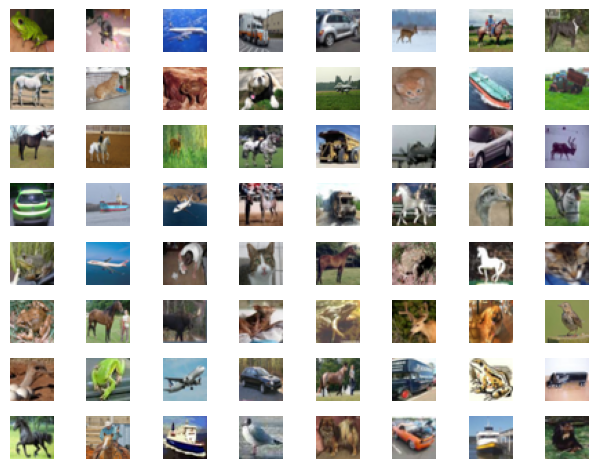

In [ ]:
# look at some images...

In [ ]:
# split train, val, test ... don't forget the seed!
# val_ratio = 0.2

Total Data 10000
num_test 1000 num_val 2000 num_train 8000 sum 10000


In [ ]:
# Make torch dataset and loaders ...
# Hint:

"""
from torch.utils.data import Dataset

class NeuroDataset(Dataset):
    def __init__(self, inputs, responses):
        self.inputs = inputs.copy().astype(np.float32)
        self.inputs = np.transpose(self.inputs, (0, 3, 1, 2))
        self.inputs -= np.mean(self.inputs)
        self.inputs /= np.std(self.inputs)
        self.responses = responses.copy()

    def __getitem__(self, n):
        x = torch.tensor(self.inputs[n].copy())
        y = torch.tensor(self.responses[n].copy())
        return x, y

    def __len__(self):
        return len(self.inputs)

trainset = NeuroDataset(data['x_train'][train_ind], data['y_train'][train_ind])
trainloader = torch.utils.data.DataLoader(
  trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
...
"""

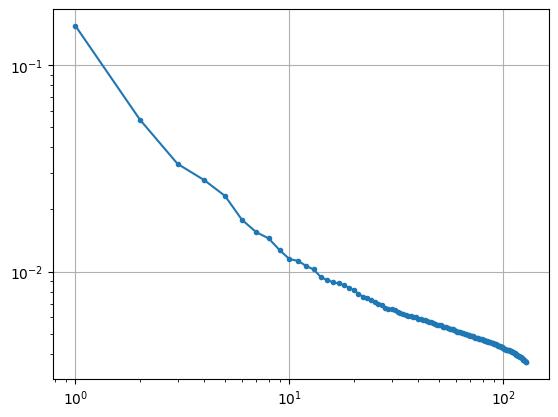

In [ ]:
# Advance / optional: Study SVD (PCA) of Data
# Hint:
"""
u, s, v = np.linalg.svd(trainset.responses, full_matrices=False)
var_exp = s ** 2 / np.sum(s ** 2)
...
"""

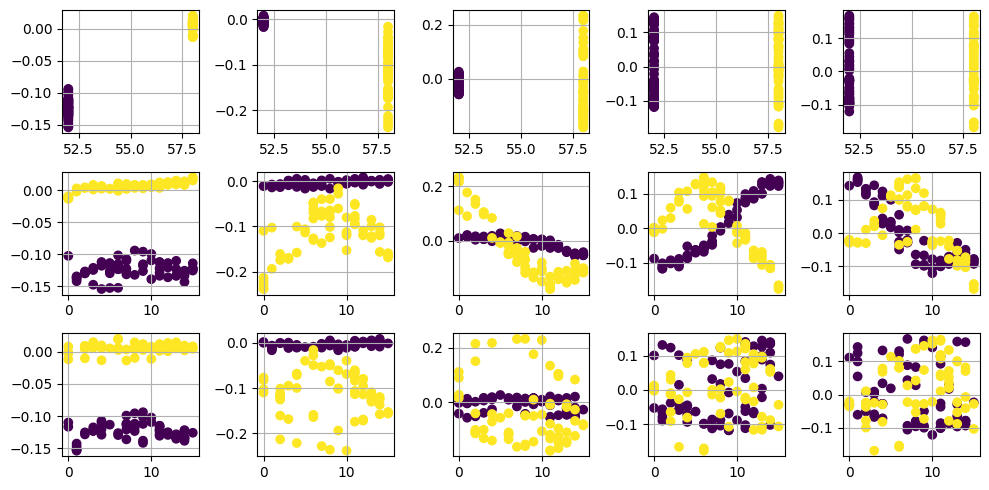

In [ ]:
# Visualize the principal components and see how they
# relate about the additional data info (position, label)...

# Fit Model

## Steps

1.   Build a pytorch model that predicts the response of each neuron.
2.   Train the model
3.   Test the model
4.   Save the model

*Advanced*

*   Build different models (Linear, MLP and CNN) and compare their performances.

*   Build the shared Core, and neuron specific Readout idea from [this paper](https://proceedings.neurips.cc/paper/2017/hash/8c249675aea6c3cbd91661bbae767ff1-Abstract.html).

In [ ]:
# Build a model

# model_linear = nn.Sequential(nn.Flatten(1), nn.Linear(32 * 32 * 3, ...

# Hints on building a Space/Feature factorized Readout:
# – if you use the code below, I will expect you to explain the logic ;)

"""
from torch import nn

class Readout(nn.Module):
  def __init__(self, num_neuron, size, num_in):
    super().__init__()
    space = torch.linspace(-1, 1, size)
    space = torch.meshgrid(space, space)
    space = torch.stack(space, 2)
    self.space = nn.Parameter(data=space, requires_grad=False)
    self.centers = nn.Parameter(
        data=torch.zeros(num_neuron, 2), requires_grad=True
    )
    self.log_widths = nn.Parameter(
        data=torch.zeros(num_neuron), requires_grad=True
    )
    self.weights = nn.Parameter(
        data=torch.randn(num_neuron, num_in), requires_grad=True
    )

  def get_kernel(self):
    centers = torch.tanh(self.centers)
    kernel = self.space[:, :, None, :] - centers[None, None, :, :]
    kernel = kernel ** 2
    kernel = torch.sum(kernel, 3)
    widths = torch.exp(self.log_widths)
    kernel = torch.exp(- kernel / widths)
    kernel = kernel / torch.sum(kernel, dim=(0, 1), keepdim=True)
    return kernel

  def forward(self, x):
    # x: N x C x H x W
    kernel = self.get_kernel()  # kernel: H x W x K
    out = x[:, :, :, :, None] * kernel[None, None, :, :, :]
    out = torch.sum(out, dim=(2, 3))  # N x C x K
    out = torch.sum(out[:, :, :] * self.weights.T[None], dim=1)
    return out


class CNN(nn.Module):
  def __init__(self, num_neuron, num_type):
    super().__init__()
    self.core = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1)),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1)),
        nn.ReLU(),
        nn.Conv2d(64, num_type, kernel_size=(5, 5), stride=(1, 1)),
    )
    self.readout = Readout(
        num_neuron=num_neuron, size=16, num_in=num_type
    )

  def forward(self, x):
    h = self.core(x)
    return self.readout(h)

...
"""

In [ ]:
# Train the model =)
# optimizer = torch.optim.Adam( ...
# criterion = ...

# train loop ...

  1%|          | 1/100 [00:02<04:47,  2.91s/it]

epoch=0 lr=3.300000e-04 train_loss=1.8114e+00 test=7.7733e-01 corr=0.0588 pos_loss=-0.0006


  6%|▌         | 6/100 [00:13<03:23,  2.17s/it]

epoch=5 lr=5.314683e-04 train_loss=1.7588e+00 test=7.2076e-01 corr=0.2315 pos_loss=-0.0817


 11%|█         | 11/100 [00:25<03:20,  2.25s/it]

epoch=10 lr=8.559350e-04 train_loss=1.6142e+00 test=5.8496e-01 corr=0.4344 pos_loss=-0.2760


 16%|█▌        | 16/100 [00:36<03:15,  2.32s/it]

epoch=15 lr=1.378492e-03 train_loss=1.5004e+00 test=4.9374e-01 corr=0.5493 pos_loss=-0.5416


 21%|██        | 21/100 [00:47<03:04,  2.33s/it]

epoch=20 lr=2.220075e-03 train_loss=1.4408e+00 test=4.3847e-01 corr=0.6278 pos_loss=-0.8970


 26%|██▌       | 26/100 [00:58<02:40,  2.17s/it]

epoch=25 lr=2.393485e-03 train_loss=1.4209e+00 test=4.0414e-01 corr=0.6517 pos_loss=-1.3438


 31%|███       | 31/100 [01:09<02:33,  2.22s/it]

epoch=30 lr=2.580440e-03 train_loss=1.3915e+00 test=3.8964e-01 corr=0.6675 pos_loss=-1.8366


 36%|███▌      | 36/100 [01:22<02:47,  2.61s/it]

epoch=35 lr=2.276180e-03 train_loss=1.3690e+00 test=3.6563e-01 corr=0.6848 pos_loss=-2.3799


 41%|████      | 41/100 [01:34<02:34,  2.62s/it]

epoch=40 lr=2.999300e-03 train_loss=1.3513e+00 test=3.4775e-01 corr=0.6978 pos_loss=-2.8931


 46%|████▌     | 46/100 [01:45<02:04,  2.30s/it]

epoch=45 lr=2.164625e-03 train_loss=1.3267e+00 test=3.3065e-01 corr=0.6968 pos_loss=-3.5046


 51%|█████     | 51/100 [01:56<01:46,  2.18s/it]

epoch=50 lr=1.562231e-03 train_loss=1.3095e+00 test=3.1703e-01 corr=0.7046 pos_loss=-3.8832


 56%|█████▌    | 56/100 [02:08<01:40,  2.29s/it]

epoch=55 lr=1.684257e-03 train_loss=1.3015e+00 test=3.1146e-01 corr=0.7103 pos_loss=-4.1824


 61%|██████    | 61/100 [02:19<01:31,  2.34s/it]

epoch=60 lr=2.712513e-03 train_loss=1.2970e+00 test=3.1148e-01 corr=0.7214 pos_loss=-4.4924


 66%|██████▌   | 66/100 [02:30<01:19,  2.33s/it]

epoch=65 lr=2.392681e-03 train_loss=1.2879e+00 test=3.0752e-01 corr=0.7292 pos_loss=-4.7487


 71%|███████   | 71/100 [02:41<01:03,  2.18s/it]

epoch=70 lr=2.579573e-03 train_loss=1.2850e+00 test=3.0834e-01 corr=0.7332 pos_loss=-4.9193


 76%|███████▌  | 76/100 [02:52<00:53,  2.21s/it]

epoch=75 lr=1.861704e-03 train_loss=1.2708e+00 test=3.0982e-01 corr=0.7350 pos_loss=-5.0335


 81%|████████  | 81/100 [03:04<00:44,  2.34s/it]

epoch=80 lr=1.642190e-03 train_loss=1.2605e+00 test=3.0821e-01 corr=0.7434 pos_loss=-5.0901


 86%|████████▌ | 86/100 [03:15<00:33,  2.41s/it]

epoch=85 lr=9.696969e-04 train_loss=1.2433e+00 test=3.1241e-01 corr=0.7392 pos_loss=-5.1460


 91%|█████████ | 91/100 [03:26<00:19,  2.20s/it]

epoch=90 lr=5.725964e-04 train_loss=1.2333e+00 test=3.1414e-01 corr=0.7419 pos_loss=-5.1873


 96%|█████████▌| 96/100 [03:37<00:08,  2.22s/it]

epoch=95 lr=3.381124e-04 train_loss=1.2264e+00 test=3.1903e-01 corr=0.7395 pos_loss=-5.2135


100%|██████████| 100/100 [03:46<00:00,  2.27s/it]


In [ ]:
# Save the model

# ckpt_path = ...
# torch.save(model.state_dict(), ckpt_path)

# Study Model Representation

## Steps

1.   Load the model
2.   Get the predictions for the whole test set
3.   Show some true vs predicted responses for example neurons
4.   Compute the correlation (Pearson's r) between true and predicted response for every neuron
5.   See how the correlations relate to the labels and positions
6.   Study the readout weight – do they allow predicting the labels?


*Advanced*

*   Look at the learned spatial readouts, can you use those to predict the positions; If yes, extract learned positions and perform linear regression from the latent activations to each of the covariates (i.e. latent factors). Basic version: use [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) for this; Advanced: Implement the least squares estimator yourself; Pro: Derive the least squares estimator (you can write equations here), like so $L(f) = \sum_i^n (y_i - f(x_i))^2$





In [ ]:
# Load the model
# model.eval()

CNN(
  (core): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 2, kernel_size=(5, 5), stride=(1, 1))
  )
  (readout): Readout()
)

In [ ]:
# Compute the correlations on the test set predictions...

(0.7402649, 0.21983753)

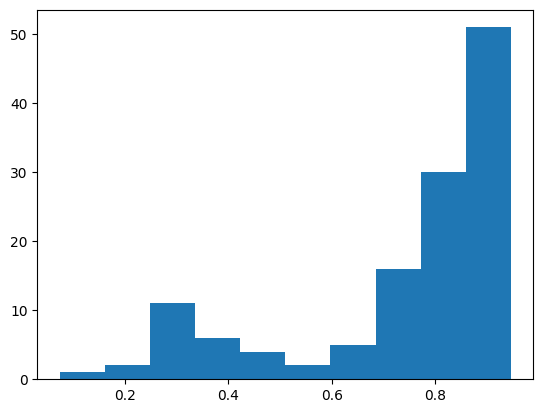

In [ ]:
# plt.hist(corrs)
# np.mean(corrs), np.std(corrs)

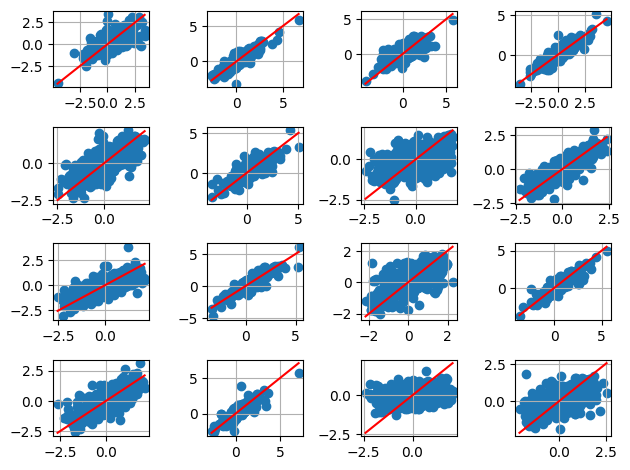

In [ ]:
# Look at some predictions

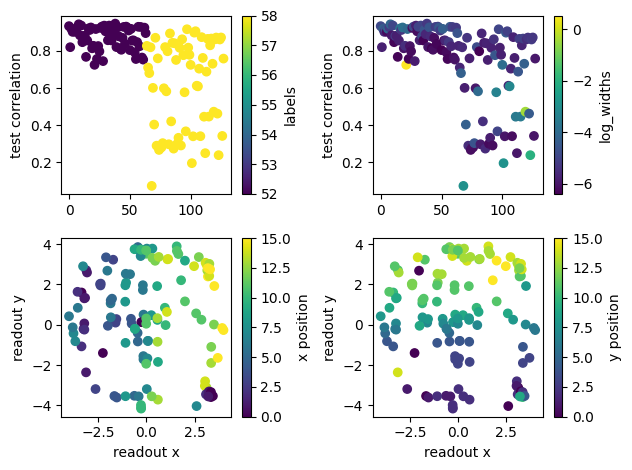

In [ ]:
# See how the correlations relate to the labels and positions

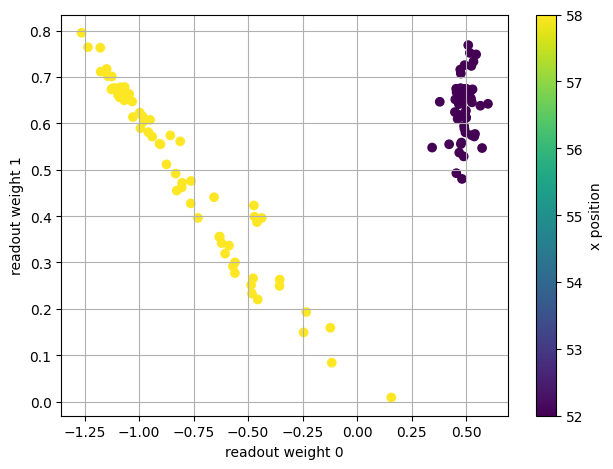

In [ ]:
# Study the readout weight – do they allow predicting the labels?

# Other Analyses

If you have other analysis ideas that come up in playing around with this data, feel free to plug them here!

*One possible (rather advanced analysis):*

How would you translate the ideas from our [Superposition paper](https://arxiv.org/pdf/2310.11431) to studying these latent representations here?

# Final Thoughts

Write a little summary of your experiments.
Try to summarize the insights you obtained.
What are your conclusions?
What follow-up analyses did your experiments inspire?
Also, do you have any feedback?